# 0.0 IMPORTS

In [10]:
import json
import numpy    as np
import pandas   as pd
import psycopg2
import seaborn  as sns

from IPython.display       import Image
from IPython.core.display  import HTML
from matplotlib            import pyplot as plt
from sqlalchemy            import create_engine

## 0.1. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    return None

jupyter_settings()

## 0.2. Loading data

### 0.1.1. Creating connection

In [4]:
with open('credentials.json') as json_file:
     credentials= json.load(json_file)
        
host = credentials['host']
port = credentials['port']
database = credentials['database']
username = credentials['username']
password = credentials['password']

db = create_engine('postgresql+psycopg2://' + username + ':' + password + '@' + host + ':' + port + '/' + database)
conn = db.connect()

### 0.1.2. Query Schemas

In [3]:
query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""

pd.read_sql(query_schema, conn)

,nspname
0,pg_toast
1,pg_temp_1
2,pg_toast_temp_1
3,pg_catalog
4,information_schema
5,public
6,pa004
7,pg_temp_4
8,pg_toast_temp_4
9,pa005


### 0.1.3. Query Tables

In [4]:
query_table = """
    SELECT tablename
    FROM pg_tables
    WHERE schemaname = 'pa004' 
"""

pd.read_sql(query_table, conn)

,tablename
0,users
1,vehicle
2,insurance


### 0.1.4. Query Join Tables

In [5]:
query_join = """
SELECT  *
FROM pa004.users u INNER JOIN pa004.insurance i USING (id)
                   INNER JOIN pa004.vehicle v   USING (id)
"""

df_raw = pd.read_sql(query_join, conn)

### 0.1.5. Close connection

In [6]:
conn.close()

# 1.0. DESCRICAO DOS DADOS

In [7]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [8]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 381109
Number of Columns: 12


## 1.2. Data Types

In [9]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 1.3. Check NA

In [10]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.4. Descriptive Statistics

In [11]:
num_attributes = df1.select_dtypes(include = [int,float])
cat_attributes = df1.select_dtypes(include = object)

## 1.4.1. Numerical Atributtes

In [16]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
7,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788
8,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302


## 1.4.2. Categorical Atributtes

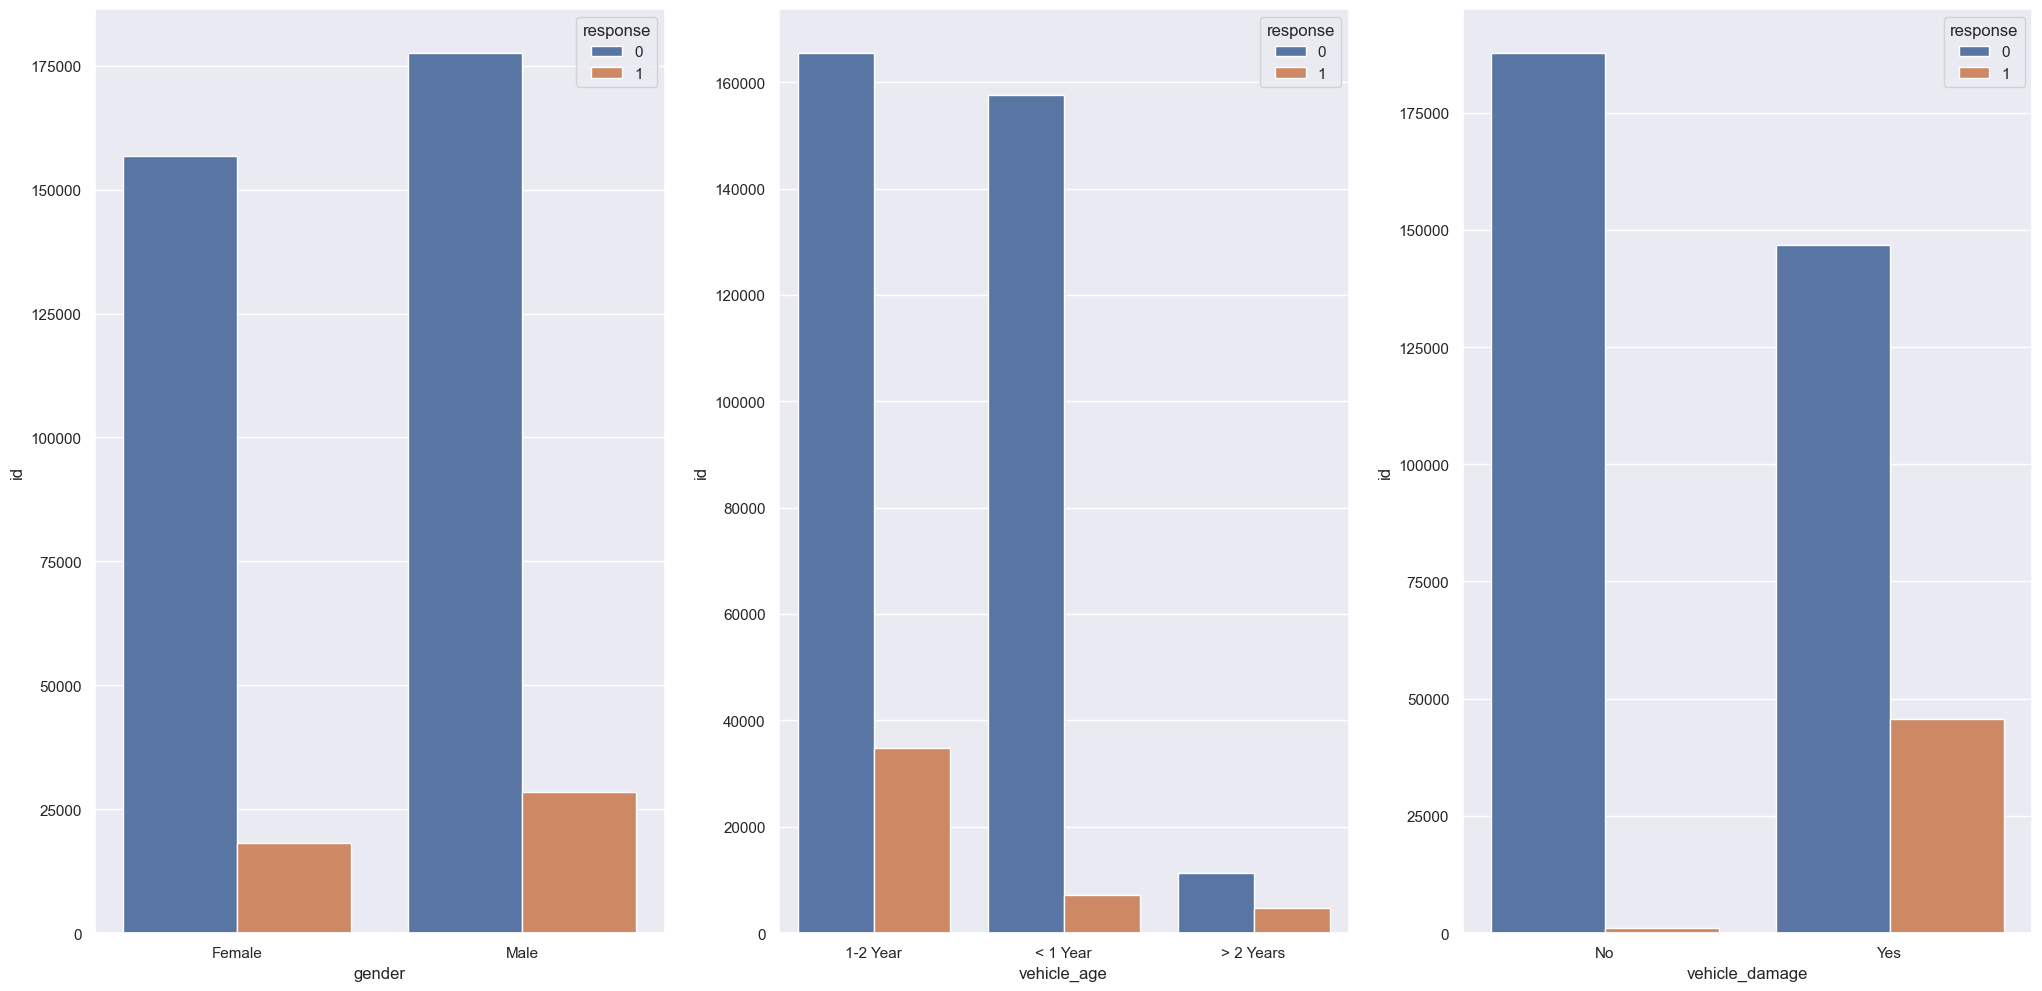

In [46]:
df_grouped = df1[['id','response', 'gender']].groupby(['gender','response']).count().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='gender', y='id', hue = 'response', data=df_grouped);

df_grouped = df1[['id','response', 'vehicle_age']].groupby(['vehicle_age','response']).count().reset_index()
plt.subplot( 1, 3, 2 )
sns.barplot( x='vehicle_age', y='id', hue = 'response', data=df_grouped);

df_grouped = df1[['id','response', 'vehicle_damage']].groupby(['vehicle_damage','response']).count().reset_index()
plt.subplot( 1, 3, 3 )
sns.barplot( x='vehicle_damage', y='id', hue = 'response', data=df_grouped);

# 2.0. FEATURE ENGINEERING

In [14]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

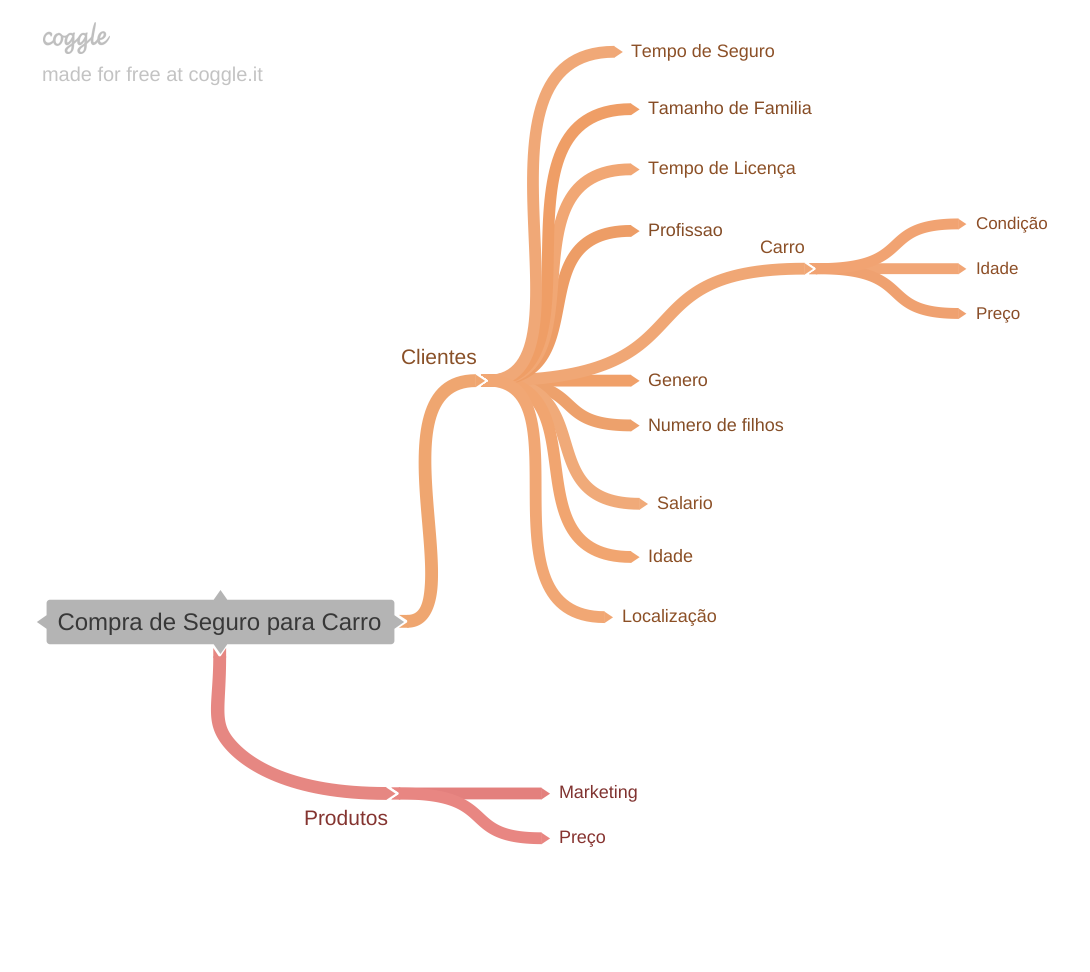

In [13]:
Image( 'images/MindMapHypothesis.png' )

## 2.2. Lista de Hipotéses

**1.** Clientes mais estão mais interessados no seguro.

**2.** Clientes que ja possuem seguro estão menos interessados no seguro.

**3.** Clientes que ja tiverem o veiculo danificado estão mais interessados no seguro.

**4.** Clientes que não possuem licença para dirigir estão menos interessados no seguro.

**5.** Clientes com carros mais velhos estão mais interessados no seguro.

## 2.3. Featuring Engineering

In [23]:
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 
                                                        'between_1_2_years' if x == '1-2 Year' else
                                                        'below_1_year')

df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0. DATA FILTERING

# 4.0. EXPLORATORY DATA ANALYSIS

In [25]:
df4 = df2.copy()